# Tutorial 4: Slide-seqV2 mouse olfactory bulb datasets

## 1 Import modules

In [1]:
import pandas as pd
import scanpy as sc
import Castl

## 2 Load data and genelist

In [2]:
adata = sc.read_h5ad("../data/SlideseqV2/Puck_200127_15_no_mito.h5ad")
adata.var_names_make_unique()
adata.obs["x_pixel"] = pd.Series(adata.obsm['spatial'][:, 1], index=adata.obs.index)
adata.obs["y_pixel"] = pd.Series(adata.obsm['spatial'][:, 0], index=adata.obs.index)
sc.pp.log1p(adata)

In [3]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/SlideseqV2/SSV2MOB_{method}_results_processed.csv'
    var_name = f'{method}_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

In [4]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/SlideseqV2/SlideseqV2_stabl/SSV2MOB_{method}_stabl_processed.csv'
    var_name = f'{method}_combined_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

## 3 Run Castl

### 3.1 Rank aggregation

gene     score  rank  pred
16982   Nrsn1  110051.0     1     1
2491    Fabp7  109902.0     2     1
5054    Doc2g  109837.0     3     1
4348    Nrxn3  109752.0     4     1
928    Tubb2a  109706.0     5     1

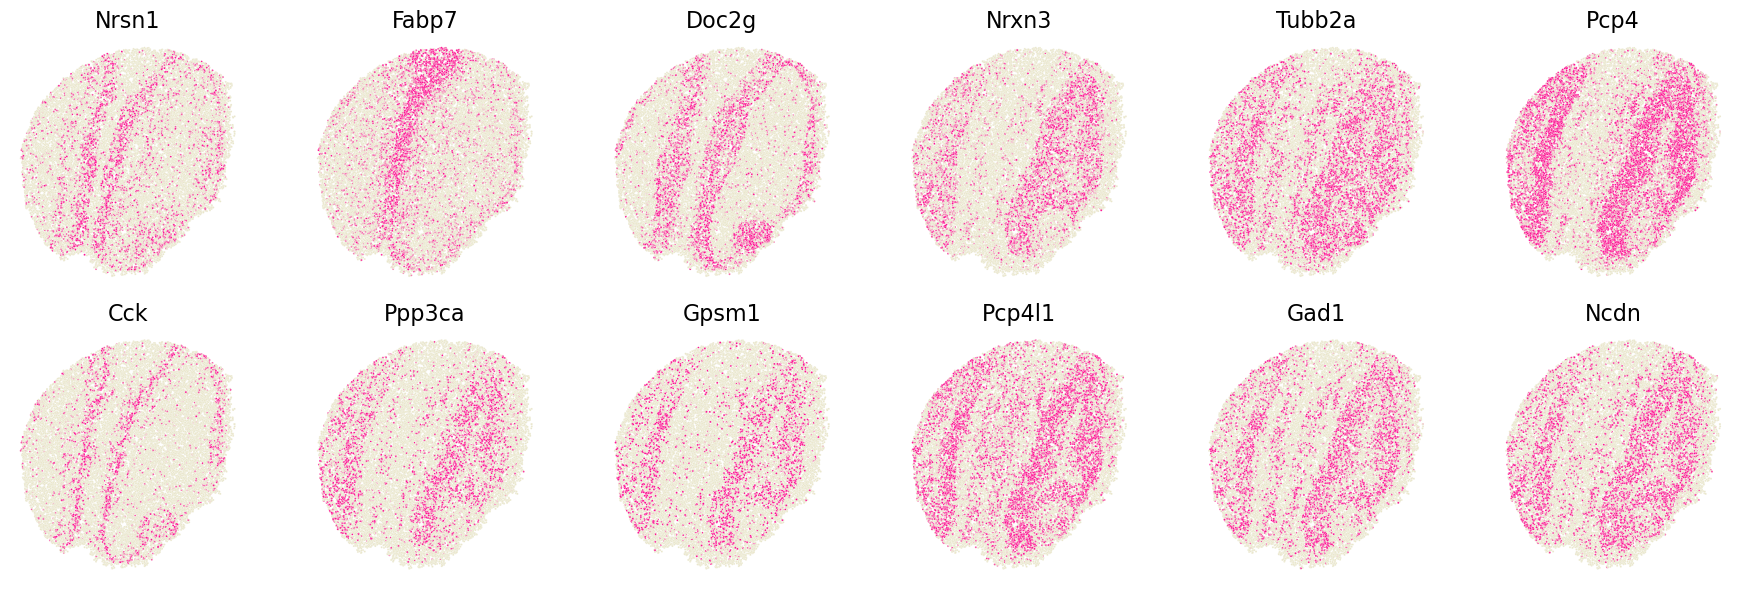

In [5]:
rank_agg_genelist = Castl.rank_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    rank_col='adjusted_p_value',
    ascending=True,
    top_percent=0.1
)

Castl.plot_gene(
    adata=adata,
    gene_df=rank_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='score',
    ascending=False,
    cmap='white_pink',
    top_n=12,
    spotsize=2,
    figsize=(18, 6),
)

rank_agg_genelist.head()

### 3.2 P-value aggregation

gene  combined_p_value  adjusted_p_value  rank  pred
15158  Tshz1               0.0               0.0     1     1
5289    Gas5               0.0               0.0     2     1
7593     Sp9               0.0               0.0     3     1
5286    Pkib               0.0               0.0     4     1
18625   Gng4               0.0               0.0     5     1

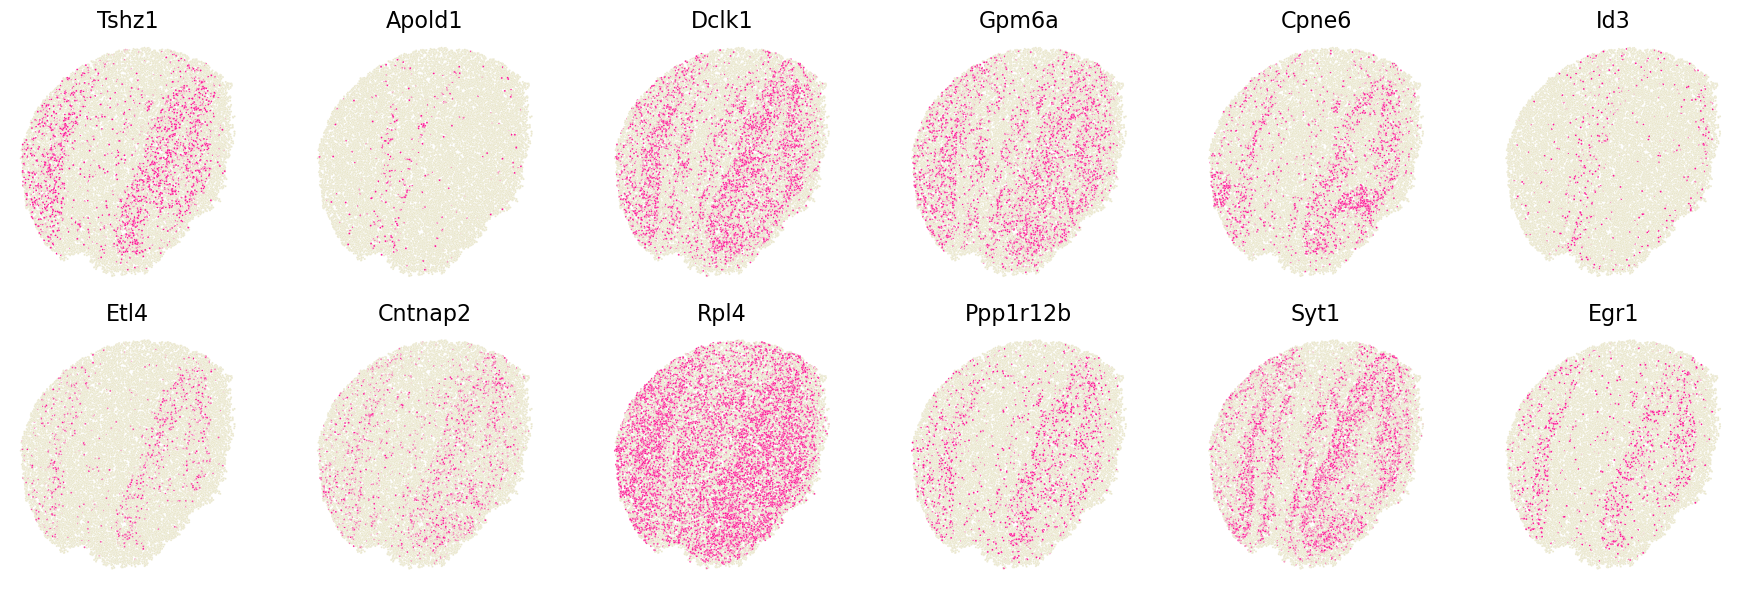

In [6]:
pval_agg_genelist = Castl.pval_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    pvalue_col='adjusted_p_value',
    correction='fdr_by'
)

Castl.plot_gene(
    adata=adata,
    gene_df=pval_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='adjusted_p_value',
    ascending=True,
    cmap='white_pink',
    top_n=12,
    spotsize=2,
    figsize=(18, 6)
)

pval_agg_genelist.head()

### 3.1 Stabl aggregation

Optimal threshold: 0.293
Total SVGs selected: 1874
ArtGene count in selection: 0
Non-ArtGene count in selection: 1874


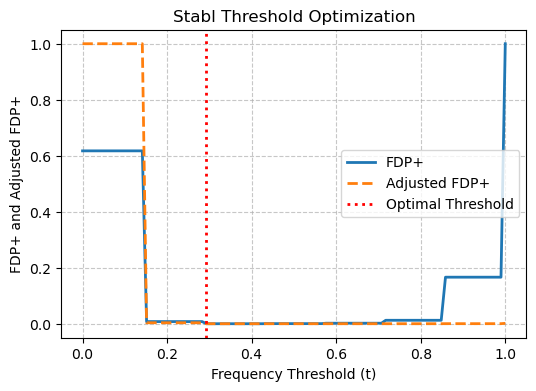

gene  frequency  rank  pred
4878    Fabp7        1.0     1     1
38782    Apod        1.0     2     1
15351   Gng13        1.0     3     1
21764  Malat1        1.0     4     1
32081   Calm1        1.0     5     1

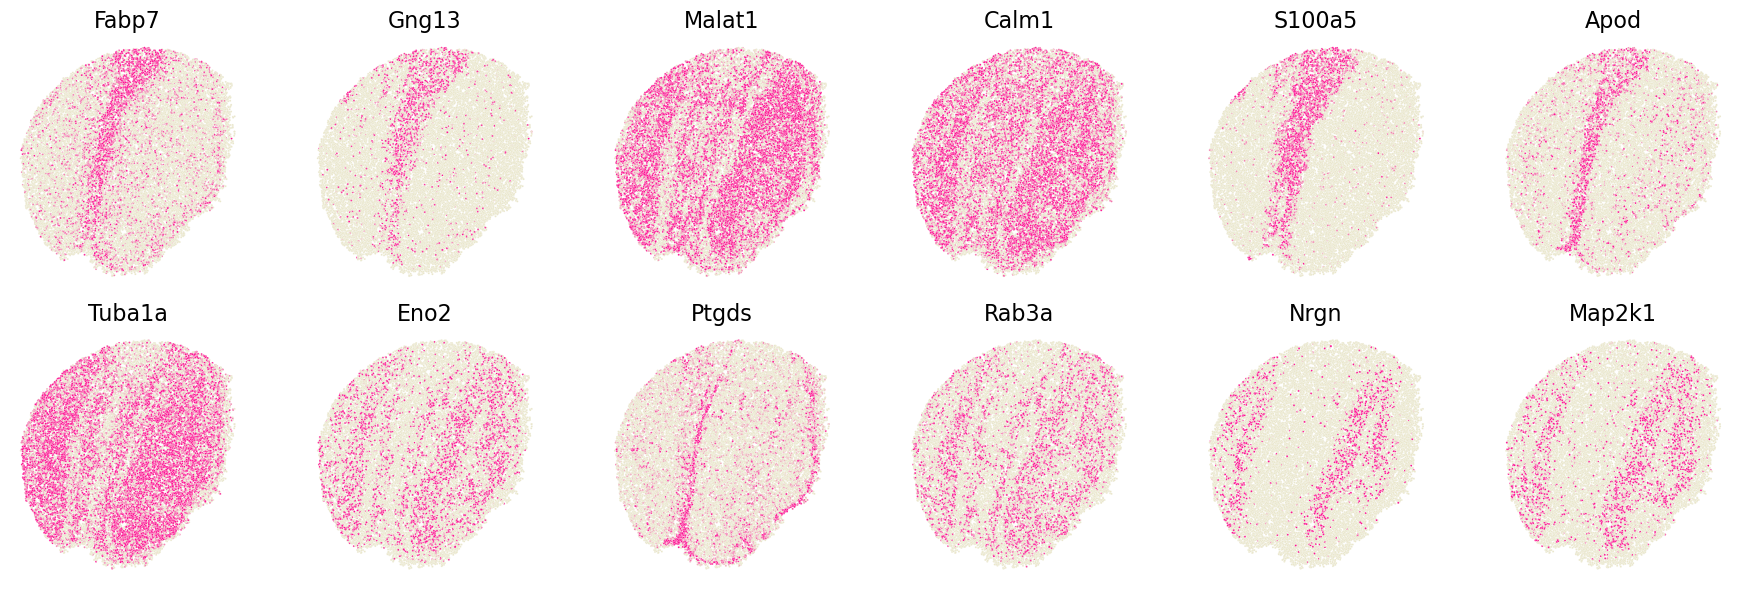

In [7]:
stabl_agg_genelist = Castl.stabl_agg(
    gene_list=[spatialde_combined_genelist, spark_combined_genelist, sparkx_combined_genelist, 
               somde_combined_genelist, spagcn_combined_genelist, spanve_combined_genelist, heartsvg_combined_genelist],
    gene_col = 'gene',
    pred_col = 'pred',
    penalty_factor=0.1,
    plot=True
)

Castl.plot_gene(
    adata=adata,
    gene_df=stabl_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='frequency',
    ascending=False,
    cmap='white_pink',
    top_n=12,
    spotsize=2,
    figsize=(18, 6)
)

stabl_agg_genelist.head()

## 4 Tissue enrichment analysis

In [8]:
%load_ext rpy2.ipython

D:\Apps\Anaconda3\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [9]:
%R -i stabl_agg_genelist

R[write to console]: 

R[write to console]: 

R[write to console]: castlRUtils package loaded.
Required packages are now available:
- Core packages: dplyr, ggplot2
- Analysis packages: clusterProfiler, org.Hs.eg.db, patchwork, TissueEnrich, SummarizedExperiment
All dependencies are ready to use.

R[write to console]: No background list provided. Using all the
                genes as background.



                 Log10PValue Tissue.Specific.Genes fold.change samples
Adipose Tissue  2.644282e-01                    18   1.2714951       5
Adrenal Gland   4.541044e+00                    48   2.0098444       3
Appendix        4.897144e-12                     5   0.3988646       3
Bone Marrow     4.897144e-12                     7   0.3598645       4
Breast          4.897144e-12                     6   0.6456041       4
Cerebral Cortex 1.528687e+02                   492   3.3476471       3
                         Tissue
Adipose Tissue   Adipose Tissue
Adrenal Gland     Adrenal Gland
Appendix               Appendix
Bone Marrow         Bone Marrow
Breast                   Breast
Cerebral Cortex Cerebral Cortex
[1] "Cerebral Cortex" "Adrenal Gland"   "Ovary"           "Heart Muscle"   
[5] "Endometrium"     "Seminal Vesicle" "Adipose Tissue"  "Cervix, uterine"


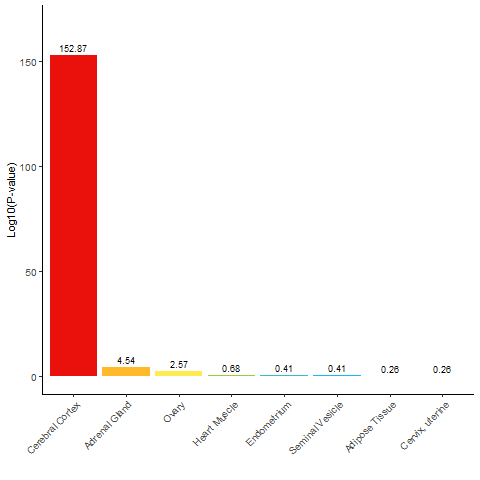

In [10]:
%%R
library(castlRUtils)

tea_results <- perform_tea(
  gene_list = stabl_agg_genelist,
  organism = "Mus Musculus",
  top_n = 8
)

print(head(tea_results$enrichment_results))
print(tea_results$top_tissues)

print(tea_results$plot)